# CIS 419/519 
#**Homework 3 : Logistic Regression**

In [1]:
import pandas as pd
import numpy as np
import math
import numpy.linalg as LA
from numpy.linalg import *

### Logistic Regression

In [4]:
class LogisticRegression:

    def __init__(self, alpha = 0.01, regLambda=0.01, regNorm=1, epsilon=0.0001, maxNumIters = 10000, initTheta = None):
        '''
        Constructor
        Arguments:
        	alpha is the learning rate
        	regLambda is the regularization parameter
        	regNorm is the type of regularization (either L1 or L2, denoted by a 1 or a 2)
        	epsilon is the convergence parameter
        	maxNumIters is the maximum number of iterations to run
          initTheta is the initial theta value. This is an optional argument
        '''
        self.alpha = alpha
        self.regLambda = regLambda
        self.regNorm = regNorm
        self.epsilon = epsilon
        self.maxNumIters = maxNumIters
        self.initTheta = initTheta
        self.sigma = 1    # the default value of sigmoid function
        self.theta = []    # the result of the gradient theta
        self.pre = []    # the 
    

    def computeCost(self, theta, X, y, regLambda):
        '''
        Computes the objective function
        Arguments:
            X is a n-by-d numpy matrix
            y is an n-by-1 numpy matrix
            regLambda is the scalar regularization constant
        Returns:
            a scalar value of the cost  ** make certain you're not returning a 1 x 1 matrix! **
        '''
        n,d = X.shape    # d, degree of regression
        yhat = self.sigmoid(X*theta)    # hypothesis y
        if self.regNorm == 2:
            cost = -np.log(yhat).T*y-np.log((np.ones((n,1))-yhat)).T*(np.ones((n,1))-y)+ regLambda*theta[1:d+1].T*theta[1:d+1]    # compute cost
        elif self.regNorm == 1:
            cost = -np.log(yhat).T*y-np.log((np.ones((n,1))-yhat)).T*(np.ones((n,1))-y)+ regLambda*np.sum(np.absolute(theta[1:d+1]))  # compute cost
        cost_scalar = cost.tolist()[0][0]    # convert matrix to scalar
        return cost_scalar

    
    def computeGradient(self, theta, X, y, regLambda):
        '''
        Computes the gradient of the objective function
        Arguments:
            X is a n-by-d numpy matrix
            y is an n-by-1 numpy matrix
            regLambda is the scalar regularization constant
        Returns:
            the gradient, an d-dimensional vector
        '''
        n,d = X.shape

        yhat = self.sigmoid(X*theta)

        gradient_0 = np.ones((1,n))*(yhat-y)    # compute gradient 0

        # compute the remain gradient
        if self.regNorm == 2:
            gradient_remain = X.T*(yhat-y)+regLambda*theta
        elif self.regNorm == 1:
            gradient_remain = X.T*(yhat-y)+regLambda
        
        gradient = np.r_[gradient_0[0],gradient_remain[1:d+1]]

        return gradient

    def fit(self, X, y):
        '''
        Trains the model
        Arguments:
            X is a n-by-d Pandas data frame
            y is an n-by-1 Pandas data frame
        Note:
            Don't assume that X contains the x_i0 = 1 constant feature.
            Standardization should be optionally done before fit() is called.
        '''
        n= len(y)
        X = X.to_numpy()
        X = np.c_[np.ones((n,1)),X]    # add a column of 1 to the matrix
        y = y.to_numpy()    # transfer y to numpy
        n,d = X.shape
        y = y.reshape(n,1)
        # initialize theta
        if self.initTheta is None:
            self.initTheta = np.matrix(np.zeros((d,1)))

        theta = self.initTheta

        for i in range(self.maxNumIters):
            old_theta = theta.copy()
            gradient = self.computeGradient(theta,X,y,self.regLambda)
            theta = theta-self.alpha*gradient    # update theta
            eps = LA.norm(old_theta-theta)
            if eps<self.epsilon:
                break
        
        self.theta = theta

    def predict(self, X):
        '''
        Used the model to predict values for each instance in X
        Arguments:
            X is a n-by-d Pandas data frame
        Returns:
            an n-by-1 dimensional Pandas data frame of the predictions
        Note:
            Don't assume that X contains the x_i0 = 1 constant feature.
            Standardization should be optionally done before predict() is called.
        '''

        X_np = X.to_numpy()
        n,d = X.shape
        X_np_1 = np.c_[np.ones((n,1)),X_np]    # Add a row of ones for the bias
        pre_y = self.sigmoid(X_np_1*self.theta)    # the predict data
        self.pre = pd.DataFrame(pre_y)    # convert the ndarray to dataframe
        result = self.predict_proba(X)    # predict the class probability for each instance in X

        return result


    def predict_proba(self, X):
        '''
        Used the model to predict the class probability for each instance in X
        Arguments:
            X is a n-by-d Pandas data frame
        Returns:
            an n-by-1 Pandas data frame of the class probabilities
        Note:
            Don't assume that X contains the x_i0 = 1 constant feature.
            Standardization should be optionally done before predict_proba() is called.
        '''
        def threshold(x):
            """
            This function use to set a threshold for predict value
            Inputs:
                x -- a numeric number
            Outputs:
                0 -- if the hypothesis y is lower than 0.5
                1 -- if the hypothesis y is higher or equal to 0.5
            """
            if x >= 0.5:
                return 1
            elif x < 0.5:
                return 0

        X = X.to_numpy()
        n,d = X.shape
        X = np.c_[np.ones((n,1)),X]    # add one row of ones for the bias
        yhat = self.pre    # returns a n-by-1 Pandas dataframe
        n = len(yhat)
        yhat.iloc[:,0] = yhat.iloc[:,0].apply(lambda x:threshold(x))    # replace the original dataframe to 0-1
        return yhat

    def sigmoid(self, Z):
        '''
        Computes the sigmoid function 1/(1+exp(-z))
        '''
        sigma = 1/(1+np.exp(-Z))

        return sigma

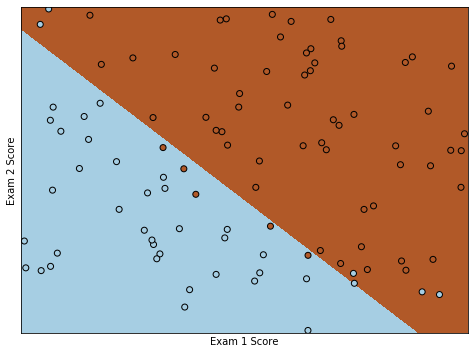

In [9]:
# Test script for training a logistic regressiom model
#
# This code should run successfully without changes if your implementation is correct
#
from numpy import loadtxt, ones, zeros, where
import numpy as np
from pylab import plot,legend,show,where,scatter,xlabel, ylabel,linspace,contour,title
import matplotlib.pyplot as plt

def test_logreg1():
    # load the data
    filepath = "http://www.seas.upenn.edu/~cis519/spring2020/data/hw3-data1.csv"
    df = pd.read_csv(filepath, header=None)

    X = df[df.columns[0:2]]
    y = df[df.columns[2]]

    n,d = X.shape

    # # Standardize features
    from sklearn.preprocessing import StandardScaler
    standardizer = StandardScaler()
    Xstandardized = pd.DataFrame(standardizer.fit_transform(X))  # compute mean and stdev on training set for standardization
    
    # train logistic regression
    logregModel = LogisticRegression(regLambda = 0.01)
    logregModel.fit(Xstandardized,y)
    
    # Plot the decision boundary
    h = .02  # step size in the mesh
    x_min = X[X.columns[0]].min() - .5
    x_max = X[X.columns[0]].max() + .5
    y_min = X[X.columns[1]].min() - .5
    y_max = X[X.columns[1]].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    allPoints = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()])
    allPoints = pd.DataFrame(standardizer.transform(allPoints))
    Z = logregModel.predict(allPoints)
    Z = np.asmatrix(Z.to_numpy())

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    # Plot the training points
    plt.scatter(X[X.columns[0]], X[X.columns[1]], c=y.ravel(), edgecolors='k', cmap=plt.cm.Paired)
    
    # Configure the plot display
    plt.xlabel('Exam 1 Score')
    plt.ylabel('Exam 2 Score')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    
    plt.show()

test_logreg1()

# Map Feature

In [10]:
def mapFeature(X, column1, column2, maxPower = 6):
    '''
    Maps the two specified input features to quadratic features. Does not standardize any features.
        
    Returns a new feature array with d features, comprising of
        X1, X2, X1 ** 2, X2 ** 2, X1*X2, X1*X2 ** 2, ... up to the maxPower polynomial
        
    Arguments:
        X is an n-by-d Pandas data frame, where d > 2
        column1 is the string specifying the column name corresponding to feature X1
        column2 is the string specifying the column name corresponding to feature X2
    Returns:
        an n-by-d2 Pandas data frame, where each row represents the original features augmented with the new features of the corresponding instance
    '''
    X1 = X[column1]    # feature 1
    X2 = X[column2]    # feature 2
    n = len(X1)
    X1_expand = X1.to_numpy()    # convert dataframe to numpy
    X2_expand = X2.to_numpy()    # convert dataframe to numpy
    poly = np.ones((n,1))

    for k in range(1,maxPower+1):
        for i in range(0,k+1):
            X_col = (X1_expand**(k-i))*(X2_expand**i)    # compute the new feature
            poly = np.c_[poly,X_col]    # add the new feature to the current feature
    
    return pd.DataFrame(poly)

# Test Logistic Regression 2

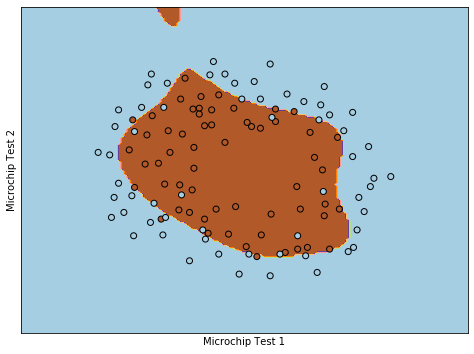

0 1


In [12]:
from numpy import loadtxt, ones, zeros, where
import numpy as np
from pylab import plot,legend,show,where,scatter,xlabel, ylabel,linspace,contour,title
import matplotlib.pyplot as plt

def test_logreg2():

    polyPower = 6

    # load the data
    filepath = "http://www.seas.upenn.edu/~cis519/spring2020/data/hw3-data2.csv"
    df = pd.read_csv(filepath, header=None)

    X = df[df.columns[0:2]]
    y = df[df.columns[2]]

    n,d = X.shape

    # map features into a higher dimensional feature space
    Xaug = mapFeature(X.copy(), X.columns[0], X.columns[1], polyPower)

    # # Standardize features
    from sklearn.preprocessing import StandardScaler
    standardizer = StandardScaler()
    Xaug = pd.DataFrame(standardizer.fit_transform(Xaug))  # compute mean and stdev on training set for standardization
    
    # train logistic regression
    logregModel = LogisticRegression(regLambda = 0.00000001, regNorm=2)
    logregModel.fit(Xaug,y)
    
    # Plot the decision boundary
    h = .02  # step size in the mesh
    x_min = X[X.columns[0]].min() - .5
    x_max = X[X.columns[0]].max() + .5
    y_min = X[X.columns[1]].min() - .5
    y_max = X[X.columns[1]].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    allPoints = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()])
    allPoints = mapFeature(allPoints, allPoints.columns[0], allPoints.columns[1], polyPower)
    allPoints = pd.DataFrame(standardizer.transform(allPoints))
    Xaug = pd.DataFrame(standardizer.fit_transform(Xaug))  # standardize data
    
    Z = logregModel.predict(allPoints)
    Z = np.asmatrix(Z.to_numpy())

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    # Plot the training points
    plt.scatter(X[X.columns[0]], X[X.columns[1]], c=y.ravel(), edgecolors='k', cmap=plt.cm.Paired)
    
    # Configure the plot display
    plt.xlabel('Microchip Test 1')
    plt.ylabel('Microchip Test 2')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    
    plt.show()


    print(str(Z.min()) + " " + str(Z.max()))

test_logreg2()

# Logistic Regression with Adagrad

In [27]:
import random

class LogisticRegressionAdagrad:

    def __init__(self, alpha = 0.01, regLambda=0.01, regNorm=2, epsilon=1E-4, maxNumIters = 5000, initTheta = None):
        '''
        Constructor
        Arguments:
        	alpha is the learning rate
        	regLambda is the regularization parameter
        	regNorm is the type of regularization (either L1 or L2, denoted by a 1 or a 2)
        	epsilon is the convergence parameter
        	maxNumIters is the maximum number of iterations to run
          initTheta is the initial theta value. This is an optional argument
        '''
        self.alpha = alpha
        self.regLambda = regLambda
        self.regNorm = regNorm
        self.epsilon = epsilon
        self.maxNumIters = maxNumIters
        self.initTheta = initTheta
        self.sigma = 1    # the default value of sigmoid function
        self.theta = []    # the result of the gradient theta
        self.pre = []    # the predict one
        self.ksi = 1E-8    # small constant to prevent dividing by zero errors

    def computeCost(self, theta, X, y, regLambda):
        '''
        Computes the objective function
        Arguments:
            X is a n-by-d numpy matrix
            y is an n-by-1 numpy matrix
            regLambda is the scalar regularization constant
        Returns:
            a scalar value of the cost  ** make certain you're not returning a 1 x 1 matrix! **
            '''
        n,d = X.shape    # d, degree of regression
        yhat = self.sigmoid(X*theta)    # hypothesis y
        if self.regNorm == 2:
            cost = -np.log(yhat+1E-8).T*y-np.log((np.ones((n,1))-yhat)+1E-8).T*(np.ones((n,1))-y)+ regLambda*theta[1:d+1].T*theta[1:d+1]    # compute cost
        elif self.regNorm == 1:
            cost = -np.log(yhat+1E-8).T*y-np.log((np.ones((n,1))-yhat)+1E-8).T*(np.ones((n,1))-y)+ regLambda*np.sum(np.absolute(theta[1:d+1]))  # compute cost
        cost_scalar = cost.tolist()[0][0]    # convert matrix to scalar
        return cost_scalar

    
    def computeGradient(self, theta, X, y, regLambda):
        '''
        Computes the gradient of the objective function
        Arguments:
            X is a n-by-d numpy matrix
            y is an n-by-1 numpy matrix
            regLambda is the scalar regularization constant
        Returns:
            the gradient, an d-dimensional vector
        '''

        n,d = X.shape

        yhat = self.sigmoid(X*theta)

        gradient_0 = X.T*(yhat-y)    # compute gradient 0

        # compute the remain gradient
        if self.regNorm == 2:
            gradient_remain = X.T*(yhat-y)+regLambda*theta
        elif self.regNorm == 1:
            gradient_remain = X.T*(yhat-y)+regLambda*np.sign(theta)
        
        gradient = np.r_[gradient_0[0],gradient_remain[1:d+1]]

        return gradient

    def hasConverged(self,oldtheta,newtheta,epsilon,X,y,regLambda):
        """
        Detect the convergence based on the cost
        Returns:
        a boolean, whether the cost has converge
        """
        old_cost = self.computeCost(oldtheta,X,y,regLambda)
        new_cost = self.computeCost(newtheta,X,y,regLambda)
        d_cost = abs(old_cost-new_cost)    # compute the difference between old cost and new cost

        # print(d_cost)

        if d_cost<epsilon:
            bool_converged = 1
        else:
            bool_converged =0

        return bool_converged

    def fit(self, X, y):
        '''
        Trains the model
        Arguments:
            X is a n-by-d Pandas data frame
            y is an n-by-1 Pandas data frame
        Note:
            Don't assume that X contains the x_i0 = 1 constant feature.
            Standardization should be optionally done before fit() is called.
        '''
        # random.seed(42)
        n = X.shape[0]
        X = X.to_numpy()
        # print(X)
        X = np.c_[np.ones((n,1)),X]    # add a column of 1 to the matrix
        y = y.to_numpy()    # transfer y to numpy
        n,d = X.shape
        y = y.reshape(-1,1)
        alpha_t = np.zeros((d,1))
        G = np.zeros((d,1))

        # initialize theta
        if self.initTheta is None:
            self.initTheta = np.matrix(np.zeros((d,1)))

        theta = self.initTheta
        idx = list(range(0,n))    # row index of the dataframe

        # randomly shuffle the dataset
        random.shuffle(idx)    # get the shuffled index of the dataframe

        # get the training data after shuffle
        X_backup = X.copy()
        y_backup = y.copy()
        Shuffle_X = X_backup[idx,:]    # X after shuffle
        Shuffle_y = y_backup[idx,:]    # y after shuffle

        X = Shuffle_X.copy()
        y = Shuffle_y.copy()

        X = np.matrix(X)
        y = np.matrix(y)

        for k in range(self.maxNumIters):
            for i in range(n):
                old_theta = theta.copy()
                gradient = self.computeGradient(theta,X[i],y[i],self.regLambda)    # update gradient
                G = G + np.square(gradient)
                alpha_t = self.alpha/(np.sqrt(G)+self.ksi)    # update alpha
                theta = theta-np.multiply(alpha_t,gradient)    # update theta
                # if LA.norm(old_theta-theta)<1E-4:
                #     break
            bool_cost = self.hasConverged(old_theta,theta,self.epsilon,X,y,self.regLambda)
            if bool_cost==1:
                break
        print(k)

        self.theta = theta


    def predict(self, X):
        '''
        Used the model to predict values for each instance in X
        Arguments:
            X is a n-by-d Pandas data frame
        Returns:
            an n-by-1 dimensional Pandas data frame of the predictions
        Note:
            Don't assume that X contains the x_i0 = 1 constant feature.
            Standardization should be optionally done before predict() is called.
        '''

        X_np = X.to_numpy()
        n,d = X.shape
        X_np_1 = np.c_[np.ones((n,1)),X_np]    # Add a row of ones for the bias
        pre_y = self.sigmoid(X_np_1*self.theta)    # the predict data
        self.pre = pd.DataFrame(pre_y)    # convert the ndarray to dataframe
        result = self.predict_proba(X)    # predict the class probability for each instance in X

        return result


    def predict_proba(self, X):
        '''
        Used the model to predict the class probability for each instance in X
        Arguments:
            X is a n-by-d Pandas data frame
        Returns:
            an n-by-1 Pandas data frame of the class probabilities
        Note:
            Don't assume that X contains the x_i0 = 1 constant feature.
            Standardization should be optionally done before predict_proba() is called.
        '''
        def threshold(x):
            """
            This function use to set a threshold for predict value
            Inputs:
                x -- a numeric number
            Outputs:
                0 -- if the hypothesis y is lower than 0.5
                1 -- if the hypothesis y is higher or equal to 0.5
            """
            if x >= 0.5:
                return 1
            elif x < 0.5:
                return 0

        X = X.to_numpy()
        n,d = X.shape
        X = np.c_[np.ones((n,1)),X]    # add one row of ones for the bias
        yhat = self.pre    # returns a n-by-1 Pandas dataframe
        n = len(yhat)
        yhat.iloc[:,0] = yhat.iloc[:,0].apply(lambda x:threshold(x))    # replace the original dataframe to 0-1
        return yhat


    def sigmoid(self, Z):
        '''
        Computes the sigmoid function 1/(1+exp(-z))
        '''
        sigma = 1/(1+np.exp(-Z))

        return sigma

In [ ]:
## Learning Curve 
import random
from math import floor

def cross_validation_accuracy(LogisticRegressionClass, X,y,num_fold,random_seed):
    """
    Args:
        LogisticRegressonClass: A kind of Logistic Regression Class, could be LogisiticRegression or LogisiticRegressionAdagrad in this case
        X: Input features, n-by-d dataframe
        y: Lables, n-by-1 dataframe
        num_fold: Number of folds
        random_seed: Seed for uniform execution
    Returns:
        cvScore: The mean accuracy of the cross validation experiment
    """
    n,d = X.shape
    random.seed(random_seed)
    accuracy = []
    test_row = floor(n/num_folds)

    # randomly shuffle the dataset
    idx = list(range(0,n))
    random.shuffle(idx)    # get the shuffle index of the dataframe
    X_backup = X.copy()
    y_backup = y.copy()
    Shuffle_X = X_backup.iloc[idx,:]
    Shuffle_y = y_backup.iloc[idx,:]
    # reset index
    Shuffle_X = Shuffle_X.reset_index(drop=True)
    Shuffle_y = Shuffle_y.reset_index(drop=True)
    
    for i in range(num_folds):
        # get the test data
        X_test = Shuffle_X.iloc[i*test_row:(i+1)*test_row,:]
        y_test = Shuffle_y.iloc[i*test_row:(i+1)*test_row,:]
        # get the training data
        X_train = Shuffle_X[i*test_row:(i+1)*test_row,:]
        y_train = Shuffle_y[i*test_row:(i+1)*test_row,:]

        # train the data 
        lrc = LogisticRegressionClass
        lrc.fit(X_train,y_train)

        # Measure the test error
        y_pred = lrc.predict(X_test)    # get the predicted y lables
        acc = (y_test==y_pred).sum()/X_test.shape[0]    # store the accuracy in a single test
        accuracy.append(acc)

    cvScore = np.mean(accuracy)    # calculate the mean accuracy of the cross-validation experiment

    return cvScore